In [5]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

2.4.1
TensorFlow version: 2.4.1
Keras version: 2.4.0


In [6]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
classes = pd.read_csv("data/Train.csv")

min_width, max_width = max(classes.Width), min(classes.Width)
min_height, max_height = max(classes.Height), min(classes.Height)

print(np.mean([min_width, max_width]))
print(np.mean([min_height, max_height]))

134.0
125.0


In [8]:
classes_no = len(classes.ClassId.unique())
print("There are {} unique classes in the dataset.".format(classes_no))

There are 43 unique classes in the dataset.


Load the data and use data augmentation

In [9]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
train_path= os.path.join(base_dir, 'Train')
test_path= os.path.join(base_dir, 'Test')

In [42]:
BATCH_SIZE = 150
STEPS_PER_EPOCH = 2000
TARGET_SIZE = (32, 32)

In [43]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='grayscale',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [24]:
X_batch, y_batch = next(train_data, 15)

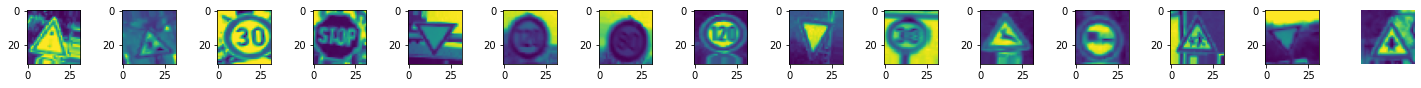

In [26]:
fig, ax = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_batch[i].reshape(32, 32))
    plt.axis("off")

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_crossentropy', patience=10)

LeNEt 5 model    

In [30]:
def leNet():
    
    filters_no=60
    filter_size=(5,5)
    filter_size2=(3,3)
    size_of_pool=(2,2)
    no_of_nodes=500

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=filters_no, kernel_size=filter_size, activation='relu', input_shape=(32, 32, 1)))
    
    model.add(layers.Conv2D(filters=filters_no, kernel_size=filter_size, activation='relu'))
    
    model.add(layers.MaxPooling2D(pool_size=size_of_pool))

    model.add(layers.Conv2D(filters=filters_no//2, kernel_size=filter_size2, activation='relu'))
    
    model.add(layers.Conv2D(filters=filters_no//2, kernel_size=filter_size2, activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=size_of_pool))

    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=no_of_nodes, activation='relu'))

    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(units=classes_no, activation = 'softmax'))
    
    return model

In [33]:
from tensorflow.keras.optimizers import Adam

lenet = leNet()
lenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=25,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/25
 33/209 [===>..........................] - ETA: 2:24 - loss: 0.1936 - accuracy: 0.9400

KeyboardInterrupt: 

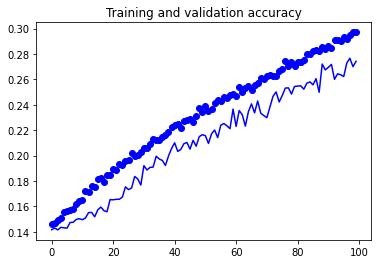

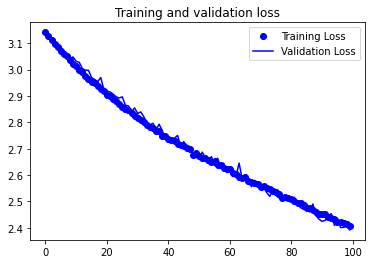

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
lenet.save('trained_model/lenet_500_epochs') 

INFO:tensorflow:Assets written to: trained_model/lenet_500_epochs\assets


In [25]:
BATCH_SIZE = 200
TARGET_SIZE = (32, 32)

In [28]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=50,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/50
156/156 [==============================] - 28s 179ms/step - loss: 1.4984 - accuracy: 0.5241 - val_loss: 1.6963 - val_accuracy: 0.4779
Epoch 2/50
156/156 [==============================] - 28s 179ms/step - loss: 1.4985 - accuracy: 0.5267 - val_loss: 1.6989 - val_accuracy: 0.4763
Epoch 3/50
156/156 [==============================] - 28s 180ms/step - loss: 1.5042 - accuracy: 0.5278 - val_loss: 1.6896 - val_accuracy: 0.4783
Epoch 4/50
156/156 [==============================] - 28s 178ms/step - loss: 1.5037 - accuracy: 0.5262 - val_loss: 1.6932 - val_accuracy: 0.4827
Epoch 5/50
156/156 [==============================] - 28s 181ms/step - loss: 1.5091 - accuracy: 0.5250 - val_loss: 1.6976 - val_accuracy: 0.4767
Epoch 6/50
156/156 [==============================] - 28s 182ms/step - loss: 1.5083 - accuracy: 0.5220 - val_loss: 1.6925 - val_accuracy: 0.4791
Epoch 7/50
156/156 [==============================] - 30s 193ms/step - loss: 1.5047 - accuracy: 0.5293 - val_loss: 1.6971 - val_ac